# Overview

This Colab helps to create and validate a training set for the k-NN classifier described in the MediaPipe [Pose Classification](https://google.github.io/mediapipe/solutions/pose_classification.html) soultion, test it on an arbitrary video, export to a CSV and then use it in the [ML Kit sample app](https://developers.google.com/ml-kit/vision/pose-detection/classifying-poses#4_integrate_with_the_ml_kit_quickstart_app).

# Step 0: Start Colab

Connect the Colab to hosted Python3 runtime (check top-right corner) and then install required dependencies.

# Codebase

## Commons

In [1]:
from matplotlib import pyplot as plt
from Bootstrap_Helper import BootstrapHelper
from EMADict_Smoothing import EMADictSmoothing
from Pose_Classifier import PoseClassifier
from Pose_embedding import FullBodyPoseEmbedder
from Pose_Sample_Outlier import PoseSampleOutlier
from Pose_Sample import PoseSample
from PoseClassification_Visualizer import PoseClassificationVisualizer
from Repetition_Counter import RepetitionCounter


def show_image(img, figsize=(10, 10)):
  """Shows output PIL image."""
  plt.figure(figsize=figsize)
  plt.imshow(img)
  plt.show()

SyntaxError: invalid syntax (3821288931.py, line 5)

In [9]:
# Required structure of the images_in_folder:
#
#   fitness_poses_images_in/
#     pushups_up/
#       image_001.jpg
#       image_002.jpg
#       ...
#     pushups_down/
#       image_001.jpg
#       image_002.jpg
#       ...
#     ...
bootstrap_images_in_folder = 'fitness_poses_images_in'

# Output folders for bootstrapped images and CSVs.
bootstrap_images_out_folder = 'fitness_poses_images_out'
bootstrap_csvs_out_folder = 'fitness_poses_csvs_out'

In [10]:
# Initialize helper.
bootstrap_helper = BootstrapHelper(
    images_in_folder=bootstrap_images_in_folder,
    images_out_folder=bootstrap_images_out_folder,
    csvs_out_folder=bootstrap_csvs_out_folder,
)

In [ ]:
# Check how many pose classes and images for them are available.
bootstrap_helper.print_images_in_statistics()

In [ ]:
# Bootstrap all images.
# Set limit to some small number for debug.
bootstrap_helper.bootstrap(per_pose_class_limit=None)

In [ ]:
# Check how many images were bootstrapped.
bootstrap_helper.print_images_out_statistics()

In [ ]:
# After initial bootstrapping images without detected poses were still saved in
# the folderd (but not in the CSVs) for debug purpose. Let's remove them.
bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

Number of images per pose class:
  hamstring_stretch_sitted_down: 70
  hamstring_stretch_sitted_up: 58
  jumping_jacks_down: 30
  jumping_jacks_up: 29


## Manual filtration

Please manually verify predictions and remove samples (images) that has wrong pose prediction. Check as if you were asked to classify pose just from predicted landmarks. If you can't - remove it.

Align CSVs and image folders once you are done.

In [ ]:
# Align CSVs with filtered images.
bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

## Automatic filtration

Classify each sample against database of all other samples and check if it gets in the same class as annotated after classification.

There can be two reasons for the outliers:

  * **Wrong pose prediction**: In this case remove such outliers.

  * **Wrong classification** (i.e. pose is predicted correctly and you aggree with original pose class assigned to the sample): In this case sample is from the underrepresented group (e.g. unusual angle or just very few samples). Add more similar samples and run bootstrapping from the very beginning.

Even if you just removed some samples it makes sence to re-run automatic filtration one more time as database of poses has changed.

**Important!!** Check that you are using the same parameters when classifying whole videos later.

In [ ]:
# Find outliers.

# Transforms pose landmarks into embedding.
pose_embedder = FullBodyPoseEmbedder()

# Classifies give pose against database of poses.
pose_classifier = PoseClassifier(
    pose_samples_folder=bootstrap_csvs_out_folder,
    pose_embedder=pose_embedder,
    top_n_by_max_distance=30,
    top_n_by_mean_distance=10)

outliers = pose_classifier.find_pose_sample_outliers()
print('Number of outliers: ', len(outliers))

Number of outliers:  3


In [ ]:
# Remove all outliers (if you don't want to manually pick).
bootstrap_helper.remove_outliers(outliers)

In [ ]:
# Align CSVs with images after removing outliers.
bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

Number of images per pose class:
  hamstring_stretch_sitted_down: 70
  hamstring_stretch_sitted_up: 56
  jumping_jacks_down: 30
  jumping_jacks_up: 28


## Dump for the App

Dump filtered poses to CSV and download it.

Please check this [guide](https://developers.google.com/ml-kit/vision/pose-detection/classifying-poses#4_integrate_with_the_ml_kit_quickstart_app) on how to use this CSV in the ML Kit sample app.

In [ ]:
import csv
import os
import numpy as np


def dump_for_the_app():
  pose_samples_folder = 'fitness_poses_csvs_out'
  pose_samples_csv_path = 'fitness_poses_csvs_out.csv'
  file_extension = 'csv'
  file_separator = ','

  # Each file in the folder represents one pose class.
  file_names = [name for name in os.listdir(pose_samples_folder) if name.endswith(file_extension)]

  with open(pose_samples_csv_path, 'w',newline='') as csv_out:
    csv_out_writer = csv.writer(csv_out, delimiter=file_separator, quoting=csv.QUOTE_MINIMAL)
    for file_name in file_names:
      # Use file name as pose class name.
      class_name = file_name[:-(len(file_extension) + 1)]

      # One file line: `sample_00001,x1,y1,x2,y2,....`.
      with open(os.path.join(pose_samples_folder, file_name)) as csv_in:
        csv_in_reader = csv.reader(csv_in, delimiter=file_separator)
        for row in csv_in_reader:
          row.insert(1, class_name)
          csv_out_writer.writerow(row)

  # files.download(pose_samples_csv_path)


dump_for_the_app()

# Step 2: Classification

**Important!!** Check that you are using the same classification parameters as while building classifier.

In [ ]:
# Specify your video name and target pose class to count the repetitions.
video_path = 'sam.mp4'
class_name='hamstring_stretch_sitted_up'
out_video_path = 'sample-out.mov'

In [ ]:
# Open the video.
import cv2

video_cap = cv2.VideoCapture(video_path)

# Get some video parameters to generate output video with classificaiton.
video_n_frames = video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
video_fps = video_cap.get(cv2.CAP_PROP_FPS)
video_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [ ]:
# Initilize tracker, classifier and counter.
# Do that before every video as all of them have state.
from mediapipe.python.solutions import pose as mp_pose


# Folder with pose class CSVs. That should be the same folder you using while
# building classifier to output CSVs.
pose_samples_folder = 'fitness_poses_csvs_out'

# Initialize tracker.
pose_tracker = mp_pose.Pose()

# Initialize embedder.
pose_embedder = FullBodyPoseEmbedder()

# Initialize classifier.
# Ceck that you are using the same parameters as during bootstrapping.
pose_classifier = PoseClassifier(
    pose_samples_folder=pose_samples_folder,
    pose_embedder=pose_embedder,
    top_n_by_max_distance=30,
    top_n_by_mean_distance=10)

# # Uncomment to validate target poses used by classifier and find outliers.
# outliers = pose_classifier.find_pose_sample_outliers()
# print('Number of pose sample outliers (consider removing them): ', len(outliers))

# Initialize EMA smoothing.
pose_classification_filter = EMADictSmoothing(
    window_size=10,
    alpha=0.2)

# Initialize counter.
repetition_counter = RepetitionCounter(
    class_name=class_name,
    enter_threshold=6,
    exit_threshold=4)

# Initialize renderer.
pose_classification_visualizer = PoseClassificationVisualizer(
    class_name=class_name,
    plot_x_max=video_n_frames,
    # Graphic looks nicer if it's the same as `top_n_by_mean_distance`.
    plot_y_max=10)

  0%|          | 0/913.0 [00:00<?, ?it/s]

C:\Users\S SM\AppData\Local\Temp\ipykernel_15668\1599513679.py:101: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')
C:\Users\S SM\AppData\Local\Temp\ipykernel_15668\1599513679.py:63: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  Image.ANTIALIAS)


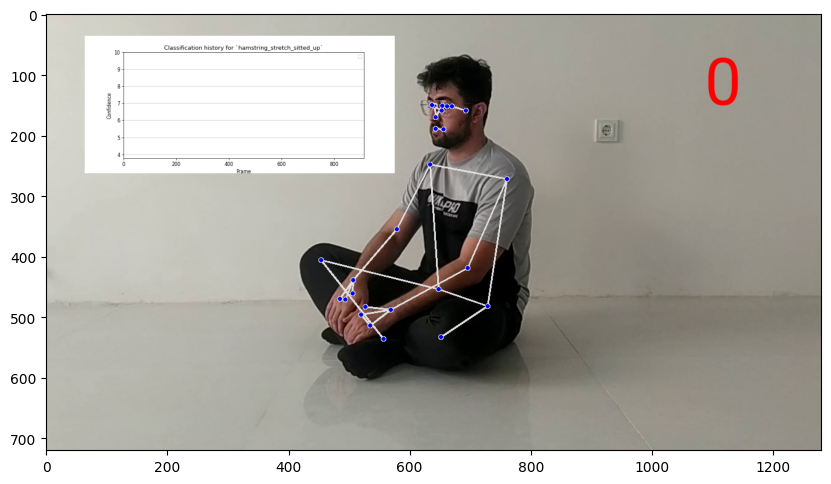

  5%|▌         | 50/913.0 [00:17<02:43,  5.29it/s] 

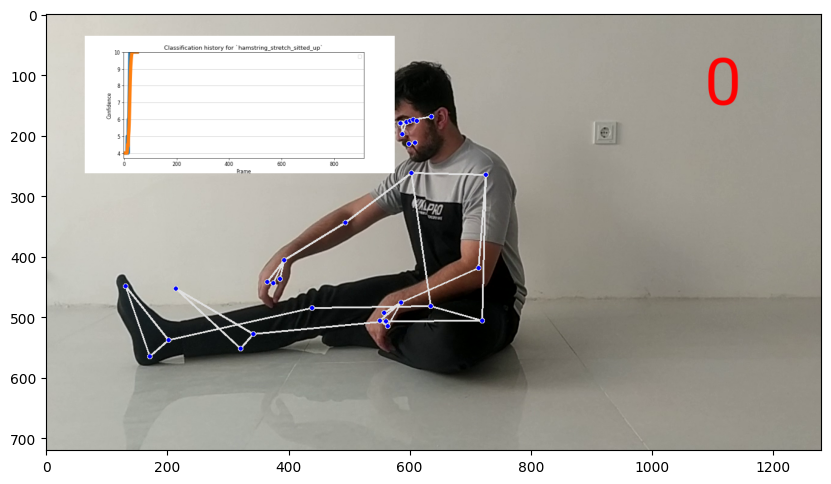

 11%|█         | 100/913.0 [00:29<03:31,  3.85it/s]

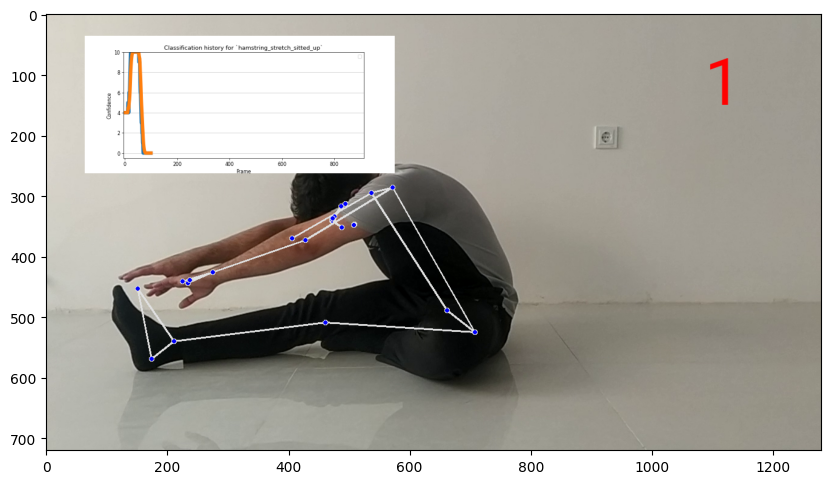

 16%|█▋        | 150/913.0 [00:42<04:29,  2.83it/s]

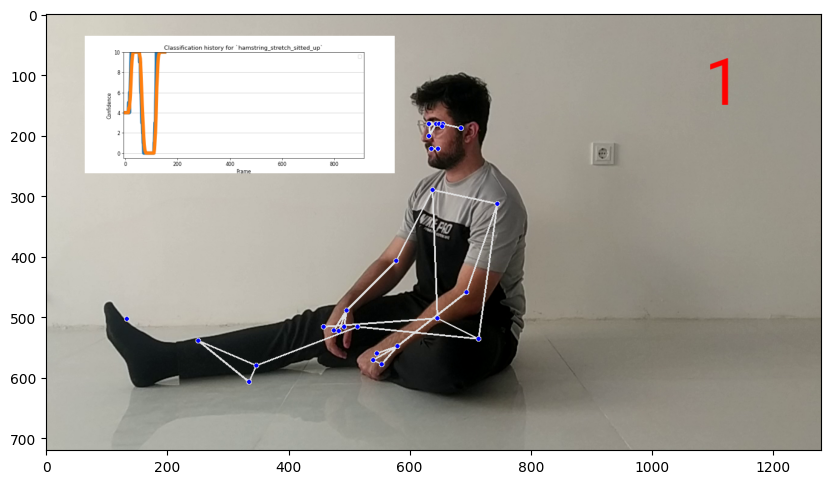

 22%|██▏       | 200/913.0 [00:54<03:04,  3.86it/s]

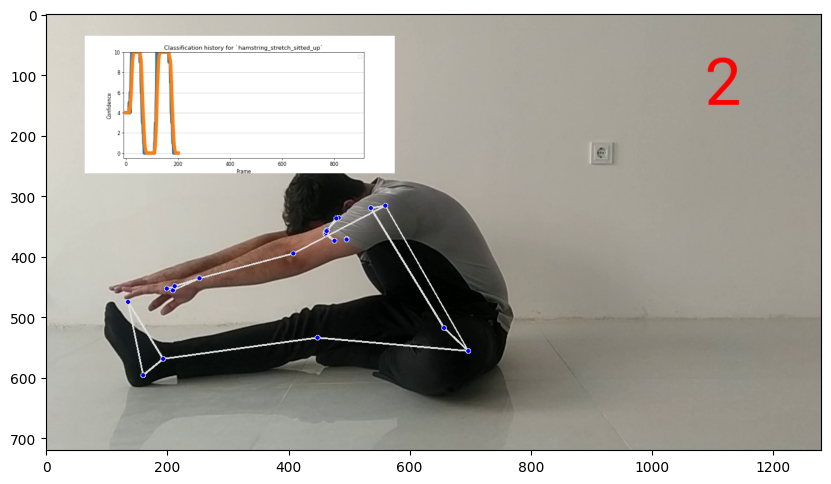

 27%|██▋       | 250/913.0 [01:07<02:41,  4.10it/s]

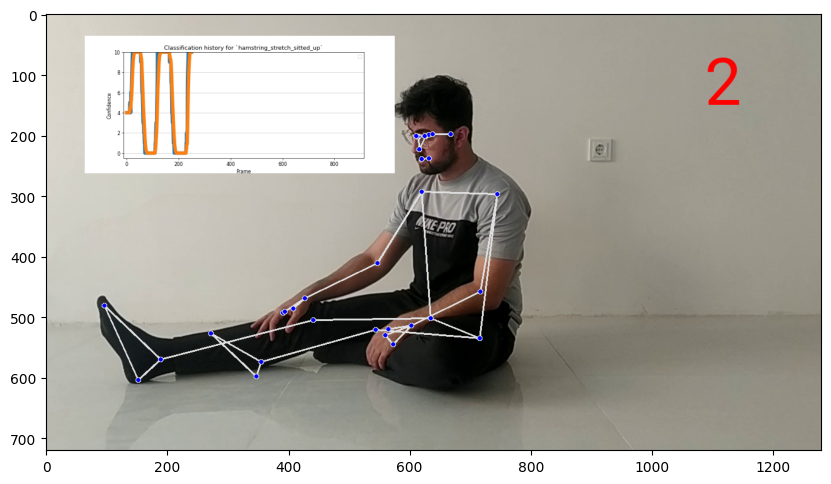

 33%|███▎      | 300/913.0 [01:20<02:37,  3.89it/s]

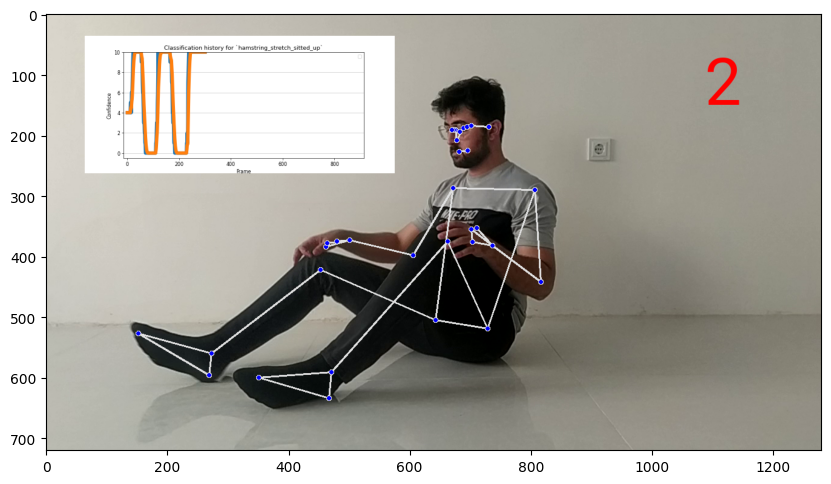

 38%|███▊      | 350/913.0 [01:32<03:30,  2.67it/s]

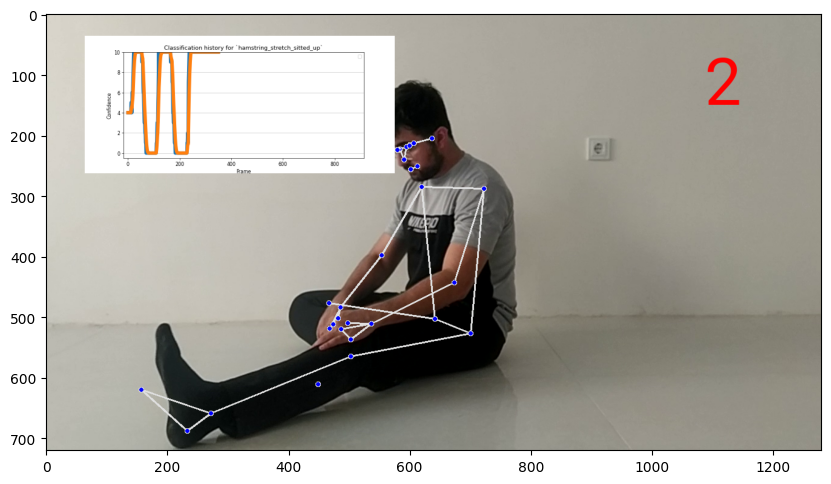

 44%|████▍     | 400/913.0 [01:43<02:05,  4.09it/s]

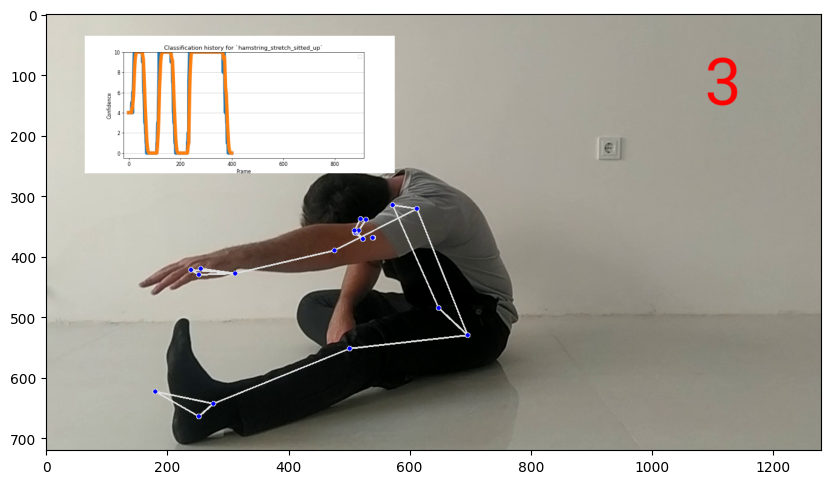

 49%|████▉     | 450/913.0 [01:56<02:32,  3.04it/s]

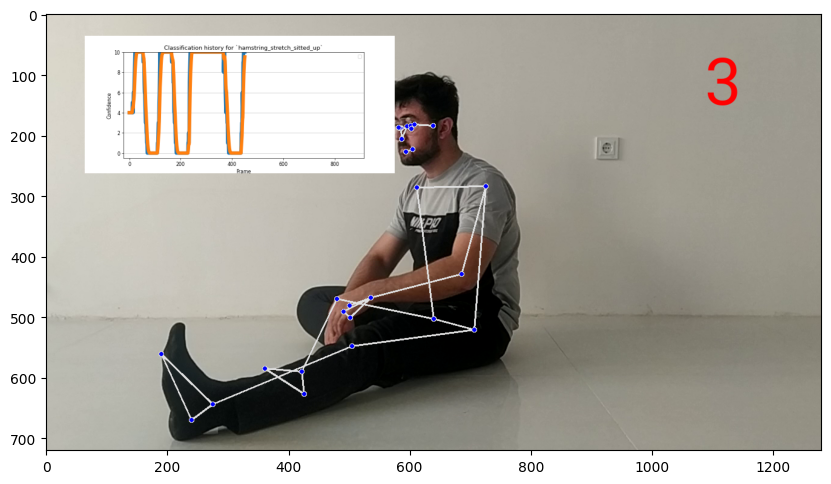

 55%|█████▍    | 500/913.0 [02:09<01:30,  4.58it/s]

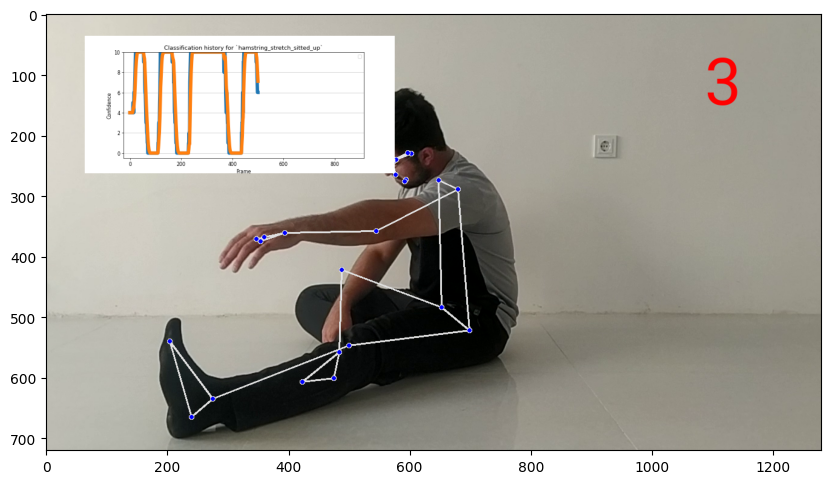

 60%|██████    | 550/913.0 [02:22<01:29,  4.04it/s]

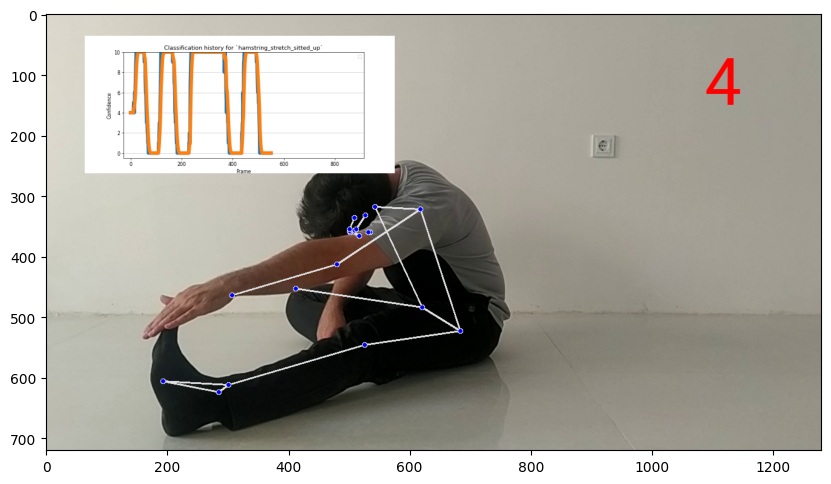

 66%|██████▌   | 600/913.0 [02:34<01:32,  3.38it/s]

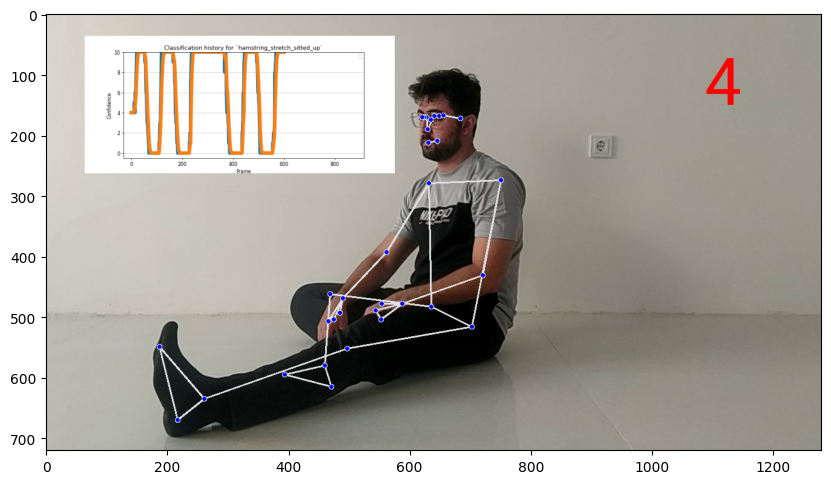

 71%|███████   | 650/913.0 [02:46<00:53,  4.90it/s]

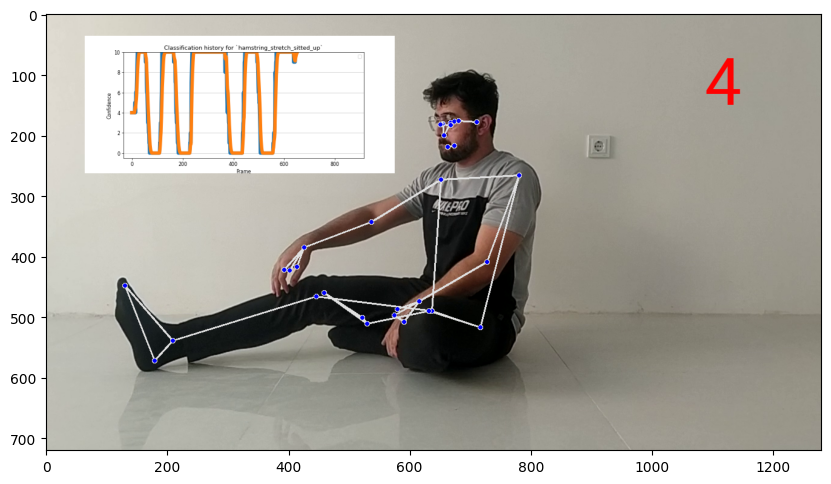

 77%|███████▋  | 700/913.0 [02:58<00:48,  4.42it/s]

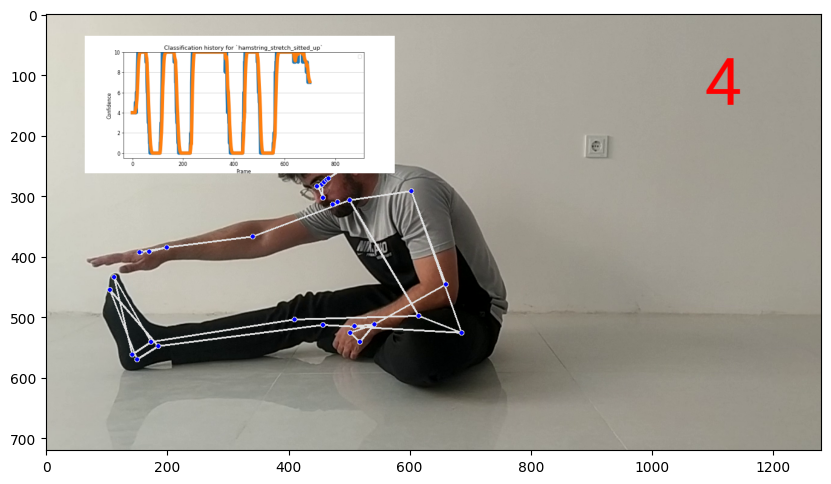

 82%|████████▏ | 750/913.0 [03:11<00:41,  3.97it/s]

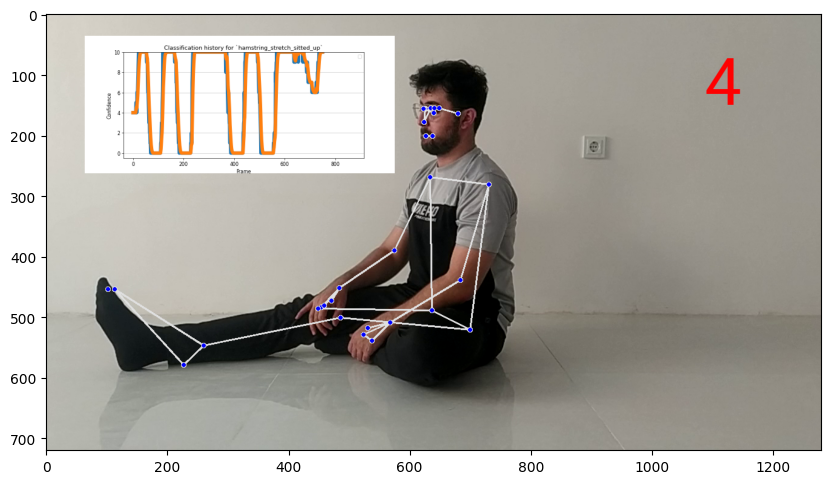

 88%|████████▊ | 800/913.0 [03:24<00:23,  4.91it/s]

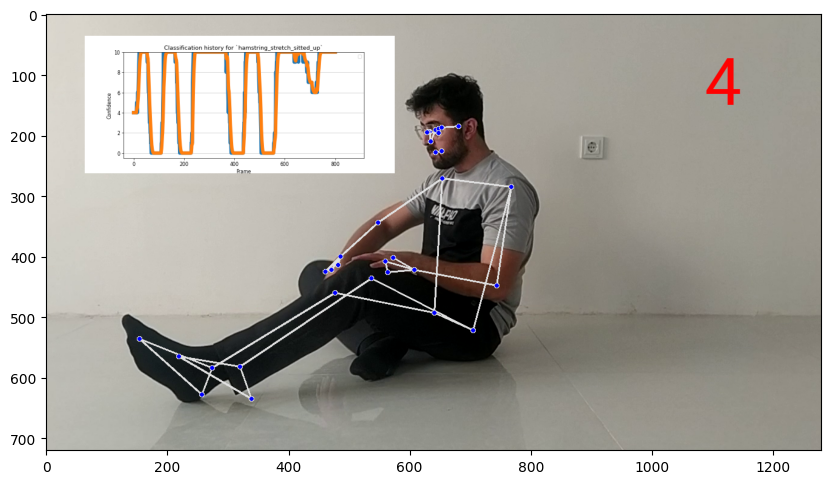

 93%|█████████▎| 850/913.0 [03:36<00:16,  3.81it/s]

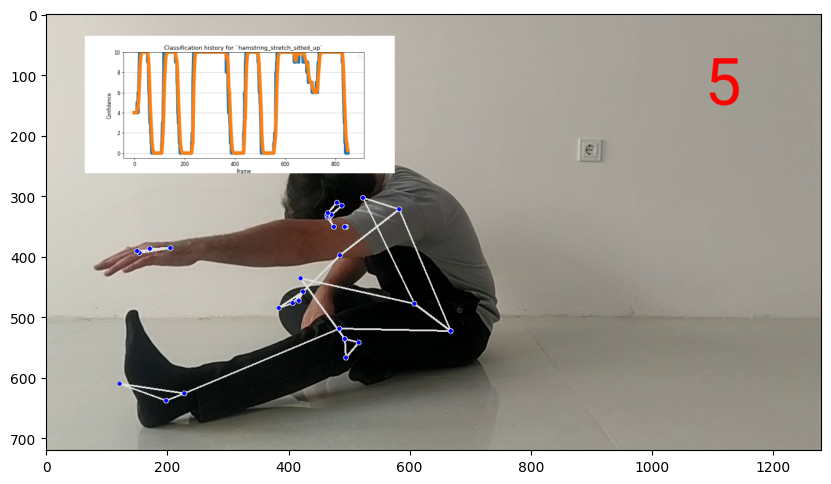

 99%|█████████▊| 900/913.0 [03:48<00:02,  4.59it/s]

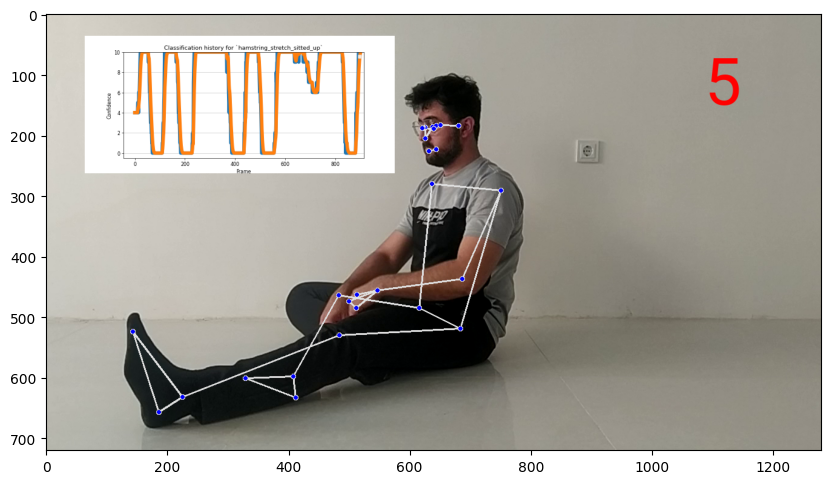

100%|██████████| 913/913.0 [03:53<00:00,  3.92it/s]


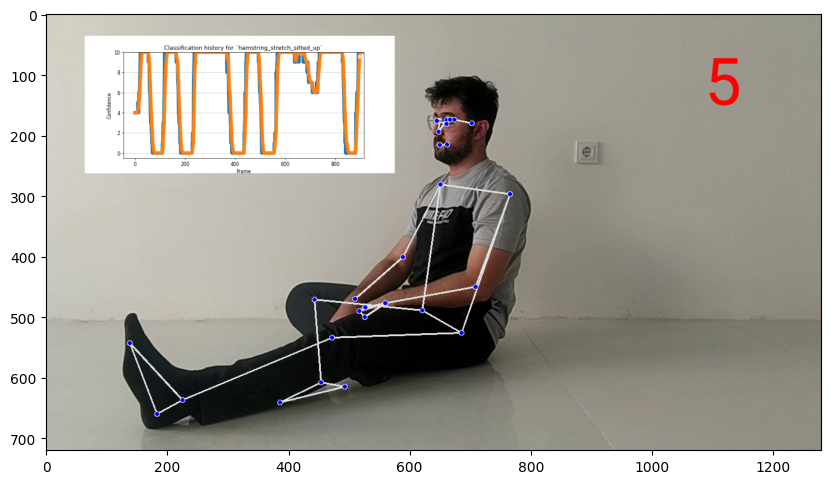

In [ ]:
# Run classification on a video.
import os
import tqdm

from mediapipe.python.solutions import drawing_utils as mp_drawing


# Open output video.
out_video = cv2.VideoWriter(out_video_path, cv2.VideoWriter_fourcc(*'mp4v'), video_fps, (video_width, video_height))

frame_idx = 0
output_frame = None
with tqdm.tqdm(total=video_n_frames, position=0, leave=True) as pbar:
  while True:
    # Get next frame of the video.
    success, input_frame = video_cap.read()
    if not success:
      break

    # Run pose tracker.
    input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
    result = pose_tracker.process(image=input_frame)
    pose_landmarks = result.pose_landmarks

    # Draw pose prediction.
    output_frame = input_frame.copy()
    if pose_landmarks is not None:
      mp_drawing.draw_landmarks(
          image=output_frame,
          landmark_list=pose_landmarks,
          connections=mp_pose.POSE_CONNECTIONS)

    if pose_landmarks is not None:
      # Get landmarks.
      frame_height, frame_width = output_frame.shape[0], output_frame.shape[1]
      pose_landmarks = np.array([[lmk.x * frame_width, lmk.y * frame_height, lmk.z * frame_width]
                                 for lmk in pose_landmarks.landmark], dtype=np.float32)
      assert pose_landmarks.shape == (33, 3), 'Unexpected landmarks shape: {}'.format(pose_landmarks.shape)

      # Classify the pose on the current frame.
      pose_classification = pose_classifier(pose_landmarks)

      # Smooth classification using EMA.
      pose_classification_filtered = pose_classification_filter(pose_classification)

      # Count repetitions.
      repetitions_count = repetition_counter(pose_classification_filtered)
    else:
      # No pose => no classification on current frame.
      pose_classification = None

      # Still add empty classification to the filter to maintaing correct
      # smoothing for future frames.
      pose_classification_filtered = pose_classification_filter(dict())
      pose_classification_filtered = None

      # Don't update the counter presuming that person is 'frozen'. Just
      # take the latest repetitions count.
      repetitions_count = repetition_counter.n_repeats

    # Draw classification plot and repetition counter.
    output_frame = pose_classification_visualizer(
        frame=output_frame,
        pose_classification=pose_classification,
        pose_classification_filtered=pose_classification_filtered,
        repetitions_count=repetitions_count)

    # Save the output frame.
    out_video.write(cv2.cvtColor(np.array(output_frame), cv2.COLOR_RGB2BGR))

    # Show intermediate frames of the video to track progress.
    if frame_idx % 50 == 0:
      show_image(output_frame)

    frame_idx += 1
    pbar.update()

# Close output video.
out_video.release()

# Release MediaPipe resources.
pose_tracker.close()

# Show the last frame of the video.
if output_frame is not None:
  show_image(output_frame)

In [ ]:
# Download generated video
# files.download(out_video_path)